In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [43]:
df= pd.read_excel("Mckinsey.xlsx")

In [45]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [47]:
df.shape

(5110, 12)

In [49]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [51]:
# Filling missing BMI values with the median
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Verifying if null values are filled
print(df['bmi'].isnull().sum())

0


C:\Users\hp\AppData\Local\Temp\ipykernel_32568\3600910440.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)


In [53]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [55]:
# Select only continuous columns
continuous_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Optionally, filter further if you have integer columns that are actually categorical
# For instance, removing integer columns with a limited number of unique values
continuous_columns = [col for col in continuous_columns if df[col].nunique() > 10]

# Display the continuous columns
print("Continuous columns:", continuous_columns)

# Select the continuous data
continuous_data = df[continuous_columns]

Continuous columns: ['id', 'age', 'avg_glucose_level', 'bmi']


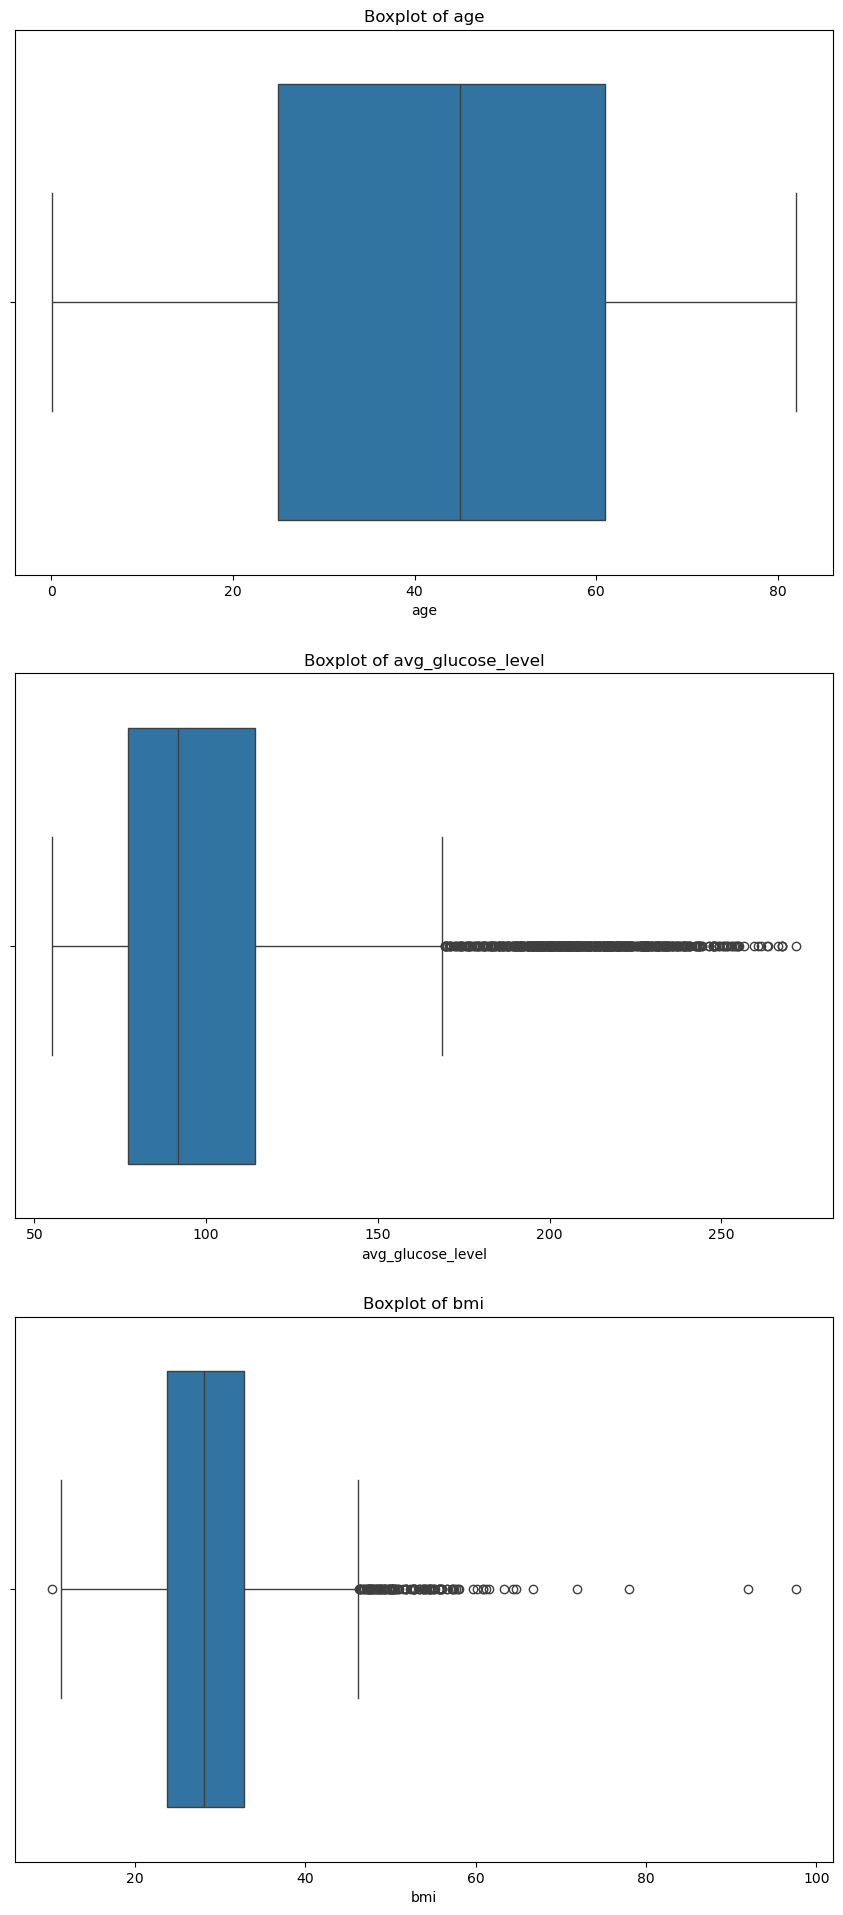

In [57]:
# Selecting continuous variables for outlier detection
continuous_cols = ['age', 'avg_glucose_level', 'bmi']

# Plotting the boxplots for continuous variables
fig, axes = plt.subplots(len(continuous_cols), 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

for i, col in enumerate(continuous_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
plt.show()

In [59]:
def handle_outliers_with_IQR(df, column):
    """ Handle outliers in a dataframe column using the IQR method.
        Values outside 1.5 * IQR from the Q1 and Q3 quartiles are considered outliers.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

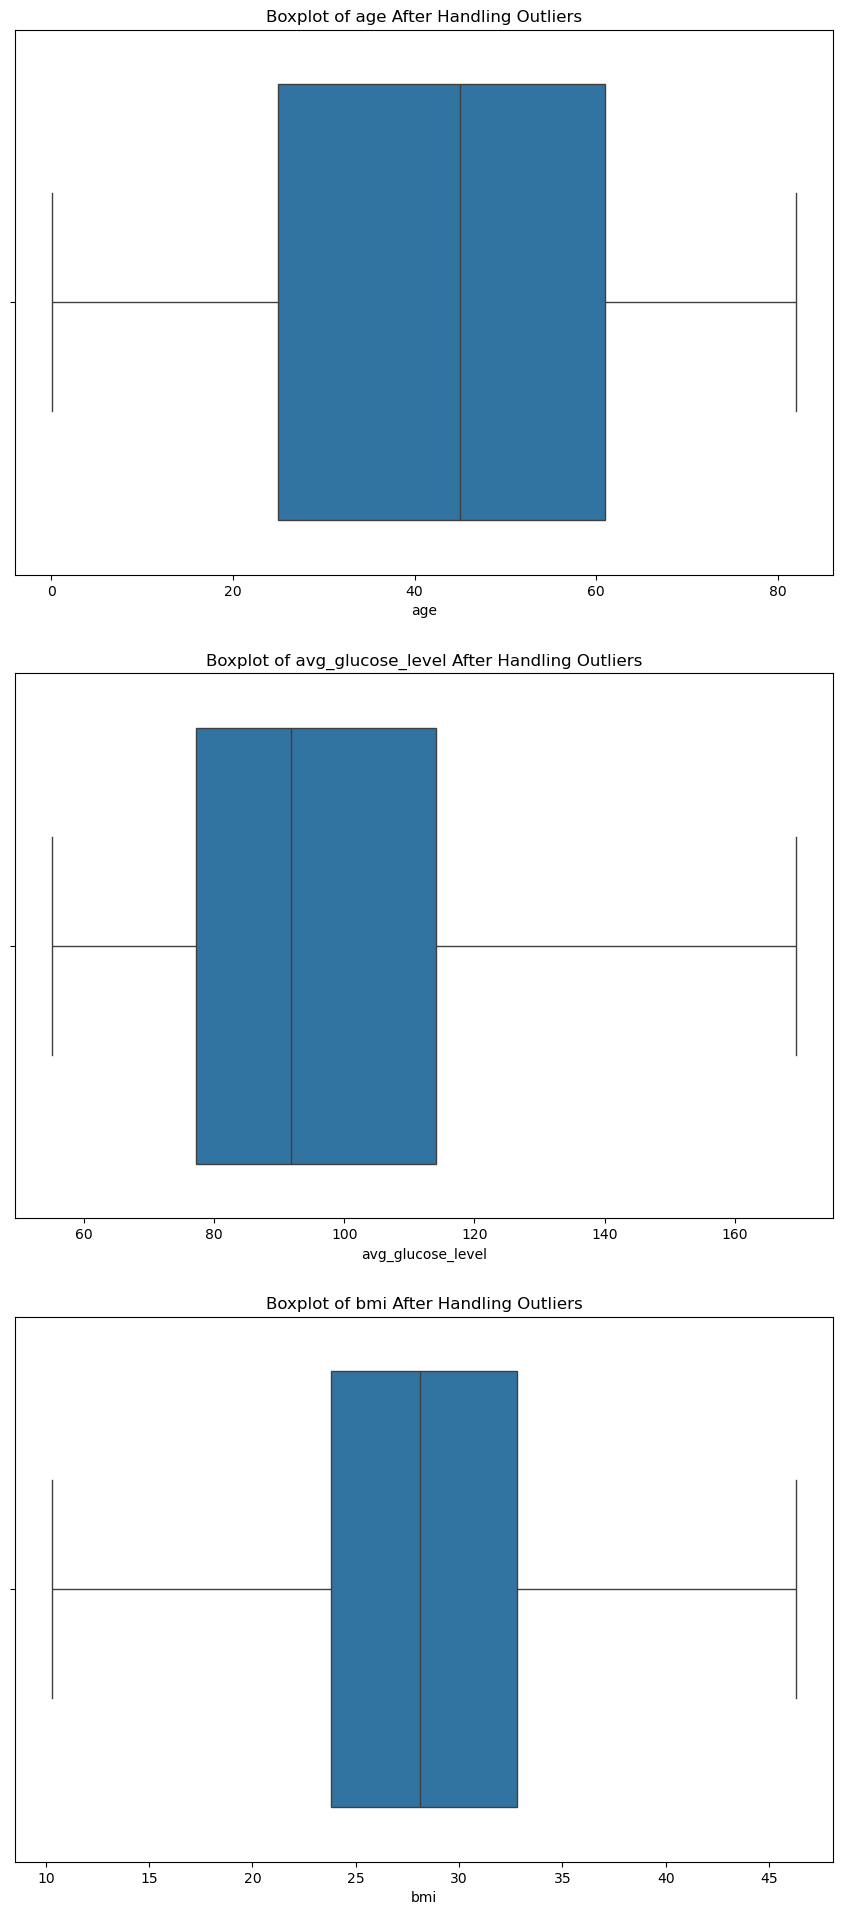

In [61]:
# Applying the IQR method to each continuous column
for col in continuous_cols:
    handle_outliers_with_IQR(df, col)

# Plotting the boxplots for continuous variables after handling outliers
fig, axes = plt.subplots(len(continuous_cols), 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

for i, col in enumerate(continuous_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} After Handling Outliers')
    axes[i].set_xlabel(col)
plt.show()

In [63]:
df = df.drop(columns=['id','Residence_type','work_type'])

In [65]:
df.shape

(5110, 9)

In [67]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,169.3575,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,169.3575,28.1,never smoked,1
2,Male,80.0,0,1,Yes,105.9200,32.5,never smoked,1
3,Female,49.0,0,0,Yes,169.3575,34.4,smokes,1
4,Female,79.0,1,0,Yes,169.3575,24.0,never smoked,1


In [73]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
categorical_columns = df.select_dtypes(include=['object']).columns  # Identify non-numeric columns
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])  # Apply Label Encoding

# Ensure all data is numeric
df = df.apply(pd.to_numeric, errors='coerce')
# Define features (X) and target variable (y)
X = df.drop(columns=['heart_disease']) 
y = df['heart_disease']

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply Robust Scaler to handle outliers and skewed data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Train SVM classifier with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train_smote)

# Predictions on test data
y_pred = svm_model.predict(X_test_scaled)

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Model Accuracy: 0.7632093933463796

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.78      0.86       967
           1       0.12      0.51      0.19        55

    accuracy                           0.76      1022
   macro avg       0.54      0.64      0.52      1022
weighted avg       0.92      0.76      0.83      1022


Confusion Matrix:
 [[752 215]
 [ 27  28]]


In [75]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# Apply Robust Scaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train_scaled, y_train_smote)

# Predictions on test data
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Model Accuracy: 0.8346379647749511

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91       967
           1       0.14      0.40      0.21        55

    accuracy                           0.83      1022
   macro avg       0.55      0.63      0.56      1022
weighted avg       0.92      0.83      0.87      1022


Confusion Matrix:
 [[831 136]
 [ 33  22]]


In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report


# Apply RobustScaler to handle outliers before feeding data into MLP
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test data

# Define and train the MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train_smote)

# Predict on test set
y_pred = mlp.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"MLP Classifier Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

MLP Classifier Accuracy: 0.8131
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.89       967
           1       0.12      0.40      0.19        55

    accuracy                           0.81      1022
   macro avg       0.54      0.62      0.54      1022
weighted avg       0.92      0.81      0.86      1022

